# EDA Project
------
#####


### Setting up the environment

 To be able to work with this notebook, here are the necessary libraries:

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from datetime import datetime
from uszipcode import SearchEngine

### Loading the data

First, import the data from the Postgre Database via psycopg2:

In [2]:
# connect to psycopg2
import psycopg2

#  load dotenv from os
import os
from dotenv import load_dotenv

load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

# Create connection object conn
conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)
# create cursor
cur = conn.cursor()

# generate query to get what we need from Postgre
query_string = "SELECT * FROM eda.king_county_house_sales JOIN eda.king_county_house_details ON eda.king_county_house_sales.house_id = eda.king_county_house_details.id"
# save in pandas dataframe
df_psycopg = pd.read_sql(query_string, conn)

#close the connection
conn.close()

#export it to a csv file
df_psycopg.to_csv('data/eda.csv', index=False)

# import the dataframe
df_housing = pd.read_csv('data/eda.csv')

### Data overview

Having everything set up, the next step is gathering general insights of the data:

In [3]:
# how many rows and columns in the dataframe?
df_housing.shape

#check column names
df_housing.columns

# basic statistics per column
df_housing.describe()

# a closer look into the duplicated ID columns shows me, that 'id' is the index and 'id.1' is something I cannot define.
df_housing[['id', 'id.1']].head(10)
df_housing[['id', 'id.1']].tail(10)
# As it is likely a remnant of my unspecified JOIN SQL-command, I think it is safe to drop it. 
df_housing = df_housing.drop('id.1', axis=1)
df_housing

#number of unique values per columns
df_housing.nunique()

# type of data in each column
df_housing.info()

#checking for duplicates
df_housing.duplicated().value_counts()

# check for missing data
df_housing.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   house_id       21597 non-null  int64  
 3   id             21597 non-null  int64  
 4   bedrooms       21597 non-null  float64
 5   bathrooms      21597 non-null  float64
 6   sqft_living    21597 non-null  float64
 7   sqft_lot       21597 non-null  float64
 8   floors         21597 non-null  float64
 9   waterfront     19206 non-null  float64
 10  view           21534 non-null  float64
 11  condition      21597 non-null  int64  
 12  grade          21597 non-null  int64  
 13  sqft_above     21597 non-null  float64
 14  sqft_basement  21145 non-null  float64
 15  yr_built       21597 non-null  int64  
 16  yr_renovated   17749 non-null  float64
 17  zipcode        21597 non-null  int64  
 18  lat   

date                0
price               0
house_id            0
id                  0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2391
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     452
yr_built            0
yr_renovated     3848
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### Data cleaning

The check for missing data shows missing values in the columns:

> waterfront, year of renovation, views, and basement sqft

In this case, *NaN* likely just means negative. No waterfront house, no renovations done, no viewings happened and house has no basement.

It makes little sense to set the year of renovation or square footage of a non-existing basement to 0, so I leave the *NaN* in there.

For views and access to waterfront, lacking information to the contrary, *NaN* can be turned into 0.


In [4]:
# replace NaN with 0
df_housing.waterfront = df_housing['waterfront'].fillna(0)
df_housing.view = df_housing['view'].fillna(0)

df_housing.waterfront.unique()

# Changing binary code into boolean (turn 1 to yes and 0 to no):
df_housing.waterfront = df_housing.waterfront.map({1: True, 0: False})
df_housing.waterfront.unique()

array([False,  True])


The df_housing.info() command reveals, that the dates in the 'date' column are object types.
To work with them, they need to be turned into datetime format.

In [5]:
# datetime is already imported (see above)
df_housing['date'] = pd.to_datetime(df_housing['date'])
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  float64       
 2   house_id       21597 non-null  int64         
 3   id             21597 non-null  int64         
 4   bedrooms       21597 non-null  float64       
 5   bathrooms      21597 non-null  float64       
 6   sqft_living    21597 non-null  float64       
 7   sqft_lot       21597 non-null  float64       
 8   floors         21597 non-null  float64       
 9   waterfront     21597 non-null  bool          
 10  view           21597 non-null  float64       
 11  condition      21597 non-null  int64         
 12  grade          21597 non-null  int64         
 13  sqft_above     21597 non-null  float64       
 14  sqft_basement  21145 non-null  float64       
 15  yr_built       2159

### Data Visualization

What is the range of the date column, anyway?

In [6]:
# what is the date range, this dataframe covers? Visualized with Boxplot
fig = px.box(df_housing.date)
fig.update_xaxes(title_text='', title_font=dict(size=16),
                ticks='outside', col=1, showline=True, linecolor='grey', mirror=True, 
                showgrid=True, gridcolor='LightGrey')
fig.update_yaxes(title_text='Time Frame',  title_font=dict(size=16),
                ticks='outside', col=1, showline=True, linecolor='grey', mirror=True, 
                showgrid=True, gridcolor='LightGrey')
fig.update_layout(title='Time Frame', title_x=0.5, title_font=dict(size=20), plot_bgcolor='white')

fig.show()


The dataframe covers the span of one year from May 2014 to May 2015.

It makes sense, to add a separate column for the month.

In [7]:
# create an additional month column
df_housing['month_sold'] = df_housing.date.dt.month
df_housing.head()

date      price    house_id  id  bedrooms  bathrooms  sqft_living  \
0 2014-10-13 221900.000  7129300520   1     3.000      1.000     1180.000   
1 2014-12-09 538000.000  6414100192   2     3.000      2.250     2570.000   
2 2015-02-25 180000.000  5631500400   3     2.000      1.000      770.000   
3 2014-12-09 604000.000  2487200875   4     4.000      3.000     1960.000   
4 2015-02-18 510000.000  1954400510   5     3.000      2.000     1680.000   

   sqft_lot  floors  waterfront  ...  sqft_above  sqft_basement  yr_built  \
0  5650.000   1.000       False  ...    1180.000          0.000      1955   
1  7242.000   2.000       False  ...    2170.000        400.000      1951   
2 10000.000   1.000       False  ...     770.000          0.000      1933   
3  5000.000   1.000       False  ...    1050.000        910.000      1965   
4  8080.000   1.000       False  ...    1680.000          0.000      1987   

   yr_renovated  zipcode    lat     long  sqft_living15  sqft_lot15  \
0         0.000    98178 47.511 -122.257       1340.000    5650.000   
1     19910.000    98125 47.721 -122.319       1690.000    7639.000   
2           NaN    98028 47.738 -122.233       2720.000    8062.000   
3         0.000    98136 47.521 -122.393       1360.000    5000.000   
4         0.000    98074 47.617 -122.045       1800.000    7503.000   

   month_sold  
0          10  
1          12  
2           2  
3          12  
4           2  

[5 rows x 23 columns]

#### Stakeholder

I chose the stakeholder Nicole Johnson. 

She would like to buy a house in a lively central neighbourhood within a medium price range. 

She would also like to know, when is the best time within a year to buy a house.

Before I go into the specifics (meaning the restrictions of N. Johnson), I want to plot general information to get a feel for the data.

A histogram shows, how many houses we sold at a certain price. The statistical metrics can be called upon with the .describe() function.

In [8]:
# plot price (cutoff at 4M)
import plotly.express as px
fig = px.histogram(df_housing, x='price', range_x=[0, 4000000])
fig.update_xaxes(title_text='House Price',
                ticks='outside', col=1, showline=True, linecolor='grey', mirror=True, 
                showgrid=True, gridcolor='LightGrey')
fig.update_yaxes(title_text='Available Houses', 
                ticks='outside', col=1, showline=True, linecolor='grey', mirror=True, 
                showgrid=True, gridcolor='LightGrey')
fig.update_layout(title='Housing Price Distribution', title_x=0.5, title_font=dict(size=20), plot_bgcolor='white')
fig.show()


In [9]:
# statistical metrics of house prices
df_housing.price.describe()

count     21597.000
mean     540296.574
std      367368.140
min       78000.000
25%      322000.000
50%      450000.000
75%      645000.000
max     7700000.000
Name: price, dtype: float64

Now, I can start cleaning the data with the wishes of N. Johnson in mind.
> "Ms. Johnson, given the price metrics generated above, what would you define as medium price range?"

> 'I consider mid-prices to be within the 25th and 75th percentile. Below that, I don't trust that the quality is enough.'

So, she wants to buy a house for at least $322000 and max $645000.

In [10]:
# create price bins according to min, max, and quartile ranges
df_housing['price_bins'] = pd.cut(df_housing.price, [78000, 322000, 450000, 645000, 7700000], labels=['lowest_range', 'lower_midrange', 'higher_midrange', 'highest_range'])
df_housing.head()

# create a list of the price range according to the price_bins created above
price_range = ['lowest_range', 'lower_midrange', 'higher_midrange', 'highest_range']
# check if it worked
price_range[0]

'lowest_range'

Does the price of a house increase with increasing house size?

In [43]:
# plot the house price against the square footage of the home
# create a scatter plot in Plotly, setting the coloring according to the pre-defined price ranges.
# The order of the legend is set according to the order of the price_range list, from lowest to highest
fig = px.scatter(df_housing, x='price', y='sqft_living', color='price_bins', 
                category_orders={'price_bins': price_range})
# formatting the axes, giving them titles, defining font sizes and showing the gridlines for better visualization
fig.update_xaxes(title_text='House Price', title_font=dict(size=16),
                ticks='outside', col=1, showline=True, linecolor='grey', mirror=True, 
                showgrid=True, gridcolor='LightGrey')
fig.update_yaxes(title_text='House size [sqft]',  title_font=dict(size=16),
                ticks='outside', col=1, showline=True, linecolor='grey', mirror=True, 
                showgrid=True, gridcolor='LightGrey')
# formatting the layout, setting the title, centering and sizing it and changing the background color to white.
fig.update_layout(title='Size-Price Comparison', title_x=0.5, title_font=dict(size=20), plot_bgcolor='white', legend_title_text='Price Range')
                
fig.show()


Not very surprisingly, the house price increases with the house size. 

Within N. Johnson's set price limits, no surprise outliers are found (too bad). There are still decently sized houses available.

Does the rating of a house have influence on the price?

In [12]:
fig = px.box(df_housing, x='grade', y='price', #color='price_bins', 
                category_orders={'price_bins': price_range})
# formatting the axes, giving them titles, defining font sizes and showing the gridlines for better visualization
fig.update_xaxes(title_text='House Ranking', title_font=dict(size=16),
                ticks='outside', col=1, showline=True, linecolor='grey', mirror=True, 
                showgrid=True, gridcolor='LightGrey')
fig.update_yaxes(title_text='House Price',  title_font=dict(size=16),
                ticks='outside', col=1, showline=True, linecolor='grey', mirror=True, 
                showgrid=True, gridcolor='LightGrey')
# formatting the layout, setting the title, centering and sizing it and changing the background color to white.
fig.update_layout(title='Ranking-Price Distribution', title_x=0.5, title_font=dict(size=20), plot_bgcolor='white', legend_title_text='Price Range')
                
fig.show()


There is a relationship between high ranking and high prices. 

Within Ms. Johnson's price range, the maximum rating she can expect is 11.

Ms. Johnson wants to know, when is the best time for her to buy.

To answer this, I create a smaller dataframe, only containing the Month a house was sold in, the price range it fell into and a count by the ID column.

In [13]:
# create a new column where the month (numeric), the house was sold in, is replaced with a str of the name of the month
df_housing['month_sold_name'] = df_housing['month_sold'].replace({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'})
df_housing.head()
df_housing_gr = df_housing[['month_sold_name', 'price_bins', 'id']].groupby(['month_sold_name', 'price_bins']).count().reset_index()
df_housing_gr.head()

month_sold_name       price_bins   id
0           April     lowest_range  478
1           April   lower_midrange  550
2           April  higher_midrange  591
3           April    highest_range  610
4          August     lowest_range  482

This can then be used to visualize house sales per month in a bar plot:

In [45]:
# creating a bar chart with plotly
# defining the database and axes, as well as a color-scheme by price range information.
fig = px.bar(df_housing_gr, x='month_sold_name', y='id', color='price_bins')
# axis formatting: setting the order of the months by array
fig.update_xaxes(title_text='',
                categoryorder='array', categoryarray= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
# giving the y-axis ticks and a gridline to better read the graph
fig.update_yaxes(title_text='No of Sales', title_font=dict(size=16),
                ticks='outside', col=1, showline=True, linecolor='grey', mirror=True, 
                showgrid=True, gridcolor='LightGrey')
# setting the title of the plot, the legend and the background
fig.update_layout(title='House Sales', title_x=0.5, title_font=dict(size=20), plot_bgcolor='white',
                legend_title_text='Price Range', margin=dict(l=80, r=80, t=100, b=80))

fig.show()

fig.write_image('data/nosalesmonthlybar.png')

It does not appear as if there was a huge difference between the timeframe and the price range of house sales. 

To visualize it better by price range, faceted plots are handy.

In [15]:
# split into 4 dataframes with only one price range/bin each
df_housing_lowest = df_housing_gr.loc[df_housing_gr.price_bins.str.contains(price_range[0])]
df_housing_lowran = df_housing_gr.loc[df_housing_gr.price_bins.str.contains(price_range[1])]
df_housing_highran =df_housing_gr.loc[df_housing_gr.price_bins.str.contains(price_range[2])]
df_housing_highest = df_housing_gr.loc[df_housing_gr.price_bins.str.contains(price_range[3])]
# check if it worked
df_housing_lowest.head()

month_sold_name    price_bins   id
0            April  lowest_range  478
4           August  lowest_range  482
8         December  lowest_range  396
12        February  lowest_range  349
16         January  lowest_range  280

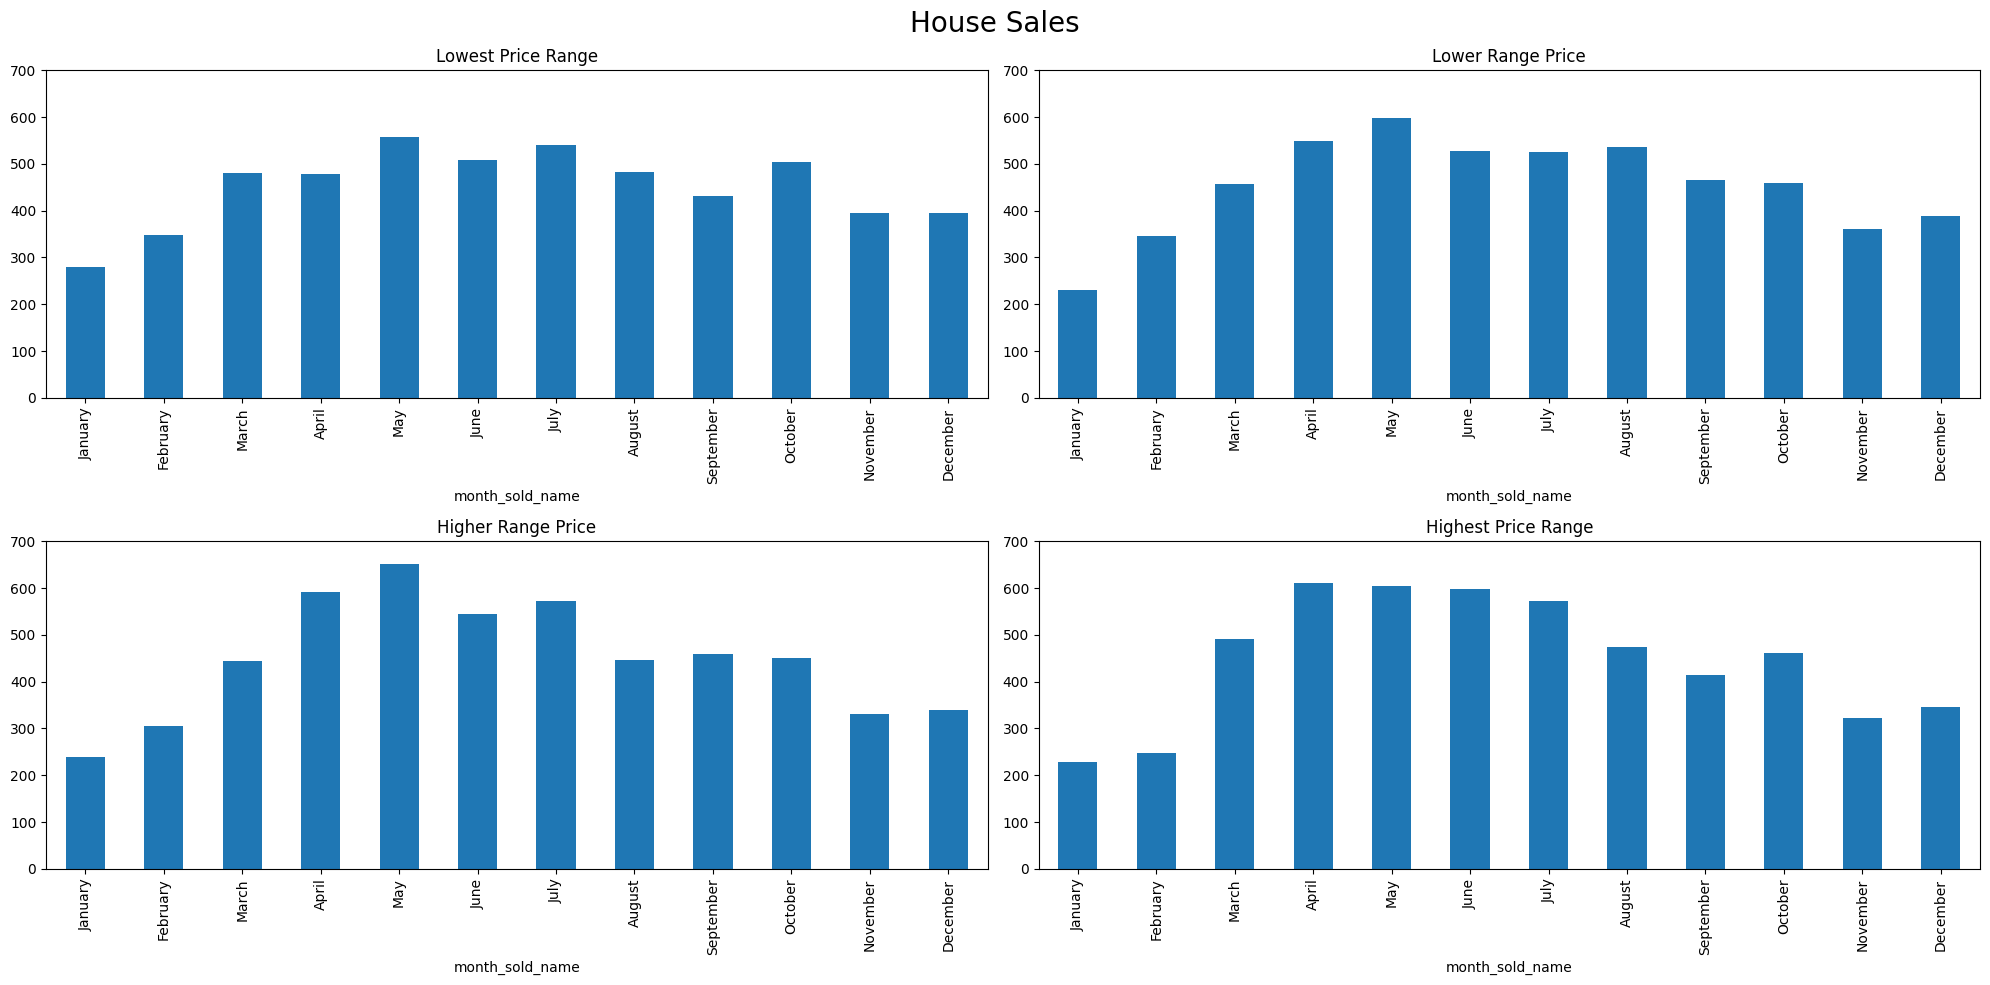

In [33]:
# to keep the order of the months as they are within a year, we define a list:
month_ls = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# create subplots on 2 rows and 3 columns
fig, ax = plt.subplots(2,2, figsize=(20,10)) 
# title of the facet plot
plt.suptitle('House Sales', fontsize=20)
# tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
fig.tight_layout() 
# adjusts the space between the single subplots
plt.subplots_adjust(hspace = .5, wspace = .2, top = .9) 

# subplots according to the dataframes with single price range defined above. 
# The correct order of the month is achieved by calling the .loc function and the list of the months.
df_housing_lowest.set_index('month_sold_name').loc[month_ls].plot(kind='bar', legend=False, ax=ax[0][0], title='Lowest Price Range', ylim=([0, 700]))

df_housing_lowran.set_index('month_sold_name').loc[month_ls].plot(kind='bar', legend=False, ax=ax[0][1], title='Lower Range Price', ylim=([0, 700]))

df_housing_highran.set_index('month_sold_name').loc[month_ls].plot(kind='bar', legend=False, ax=ax[1][0], title='Higher Range Price', ylim=([0, 700]))

df_housing_highest.set_index('month_sold_name').loc[month_ls].plot(kind='bar', legend=False, ax=ax[1][1], title='Highest Price Range', ylim=([0, 700]))

plt.tight_layout()
plt.savefig('data/facetmap')

Most houses within her price range (lower & higher) are sold in the warmer months.

Highest house sales are in April and May, but June, July, and August are also not low.

Let's see how the price ranges are distributed over King County on a map!

In [17]:
# with mapbox all prices
price_range = ['lowest_range', 'lower_midrange', 'higher_midrange', 'highest_range']

fig = px.scatter_mapbox(df_housing, lat='lat', lon='long', color='price_bins', title='King County Houses for Sale', 
                        category_orders={'price_bins': price_range})
fig.update_layout(mapbox_style='open-street-map', title_x=0.5, legend_title_text='Price Range')
fig.show()


No houses allowed in the National Parks. The Bay area is the most expensive to live in, towards Tacoma are the cheapest areas.

Downtown Seattle, as well as the Southern Seattle districts appear to have the most houses within N. Johnson's price range.

This brings us to her last condition: location! She wants to live in a lively, central area.

Checking out King County on Google Maps, I interpret this to mean Seattle and Bellevue. But assumption is good, control is better.

In [29]:
# use uszipcode to find the population density of the given zipcodes
sr = SearchEngine()

# create a smaller dataframe only containing zipcode, id and latitude and longitude (for mapping it later)
df_housing_zip = df_housing[['zipcode', 'id', 'lat', 'long']].groupby(['zipcode', 'lat', 'long']).count().reset_index()
df_housing_zip

# creating a new column mapping the population density acquired from uszipcode to the corresponding zipcodes
df_housing_zip['population_density'] = df_housing_zip['zipcode'].map(lambda x: sr.by_zipcode(x).population_density)

# using plotly mapbox, map population density over King County
fig = px.scatter_mapbox(df_housing_zip, lat='lat', lon='long', color='population_density', title='Population Density King County', 
                        )
fig.update_layout(mapbox_style='open-street-map', title_x=0.5, legend_title_text='population density')
fig.show()
fig.write_image('data/king-county-popdens-map.png')

The liveliest area is Seattle. Central can be interpreted as "as close to downtown as possible".

### Data Visualization for the stakeholder

Let's narrow down the dataset to her specific instructions!

In [19]:
#filter out all houses that are too cheap or too pricey
df_njohnson = df_housing.loc[df_housing.price_bins.isin(['lower_midrange', 'higher_midrange'])]
df_njohnson.price.describe()

# check dataset for location by zipcode
zipcode_arr = df_njohnson.zipcode.unique()
zipcode_arr.tolist()

# Narrowing down the zipcodes to show only houses in Bellevue and Downtown Seattle:
zipcode_arr
zipcode_loc = [98109, 98102, 98112, 98122, 98144, 98121, 98101, 98154, 98104, 98004]
zipcode_loc
df_njohnson.shape

# filter dataset for location by zipcode
df_njohnson = df_njohnson.loc[df_housing.zipcode.isin(zipcode_loc)]
df_njohnson.shape

(542, 25)

In [28]:
# use plotly mapbox to map the houses within her price range & preferred area

fig = px.scatter_mapbox(df_njohnson, lat='lat', lon='long', color='price', title='Suitable Houses', color_continuous_scale=px.colors.sequential.Bluered, hover_name='bedrooms')
fig.update_layout( mapbox_style='open-street-map', title_x=0.5, legend_title_text='Price Range')
fig.update_mapboxes(zoom=10.5, center_lat=47.6062, center_lon=-122.3321)
fig.show()


There are no houses for sale within Belltown or First Hill within her price range. 

She will have to settle for a place east of downtown Seattle or towards the Beaux Arts Village in southern Bellevue.

What are the rankings in her definitions?

In [21]:
# use the code from above and fit it to the new dataframe
fig = px.box(df_njohnson, x='grade', y='price', #color='price_bins', 
                category_orders={'price_bins': price_range})
# formatting the axes, giving them titles, defining font sizes and showing the gridlines for better visualization
fig.update_xaxes(title_text='House Ranking', title_font=dict(size=16),
                ticks='outside', col=1, showline=True, linecolor='grey', mirror=True, 
                showgrid=True, gridcolor='LightGrey')
fig.update_yaxes(title_text='House Price',  title_font=dict(size=16),
                ticks='outside', col=1, showline=True, linecolor='grey', mirror=True, 
                showgrid=True, gridcolor='LightGrey')
# formatting the layout, setting the title, centering and sizing it and changing the background color to white.
fig.update_layout(title='Ranking-Price Distribution', title_x=0.5, title_font=dict(size=20), plot_bgcolor='white', legend_title_text='Price Range')
                
fig.show()



Let's say, she wants at least two bathrooms and three bedrooms, in case friends are visiting.

In [22]:
# filter out the rows that do not meet both conditions
df_njohnson2 = df_njohnson.query('bedrooms >= 3 and bathrooms >= 2')
df_njohnson2.shape

(227, 25)

In [27]:
# plot locations
fig = px.scatter_mapbox(df_njohnson2, lat='lat', lon='long', color='price', title='Suitable Houses', color_continuous_scale=px.colors.sequential.Bluered, hover_name='bedrooms')
fig.update_layout(mapbox_style='open-street-map', title_x=0.5, legend_title_text='Price Range')
fig.update_mapboxes(zoom=10.5, center_lat=47.6062, center_lon=-122.3321)
fig.show()



In [24]:
# use the code from above and fit it to the new dataframe
fig = px.box(df_njohnson2, x='grade', y='price', #color='price_bins', 
                category_orders={'price_bins': price_range})
# formatting the axes, giving them titles, defining font sizes and showing the gridlines for better visualization
fig.update_xaxes(title_text='House Ranking', title_font=dict(size=16),
                ticks='outside', col=1, showline=True, linecolor='grey', mirror=True, 
                showgrid=True, gridcolor='LightGrey')
fig.update_yaxes(title_text='House Price',  title_font=dict(size=16),
                ticks='outside', col=1, showline=True, linecolor='grey', mirror=True, 
                showgrid=True, gridcolor='LightGrey')
# formatting the layout, setting the title, centering and sizing it and changing the background color to white.
fig.update_layout(title='Ranking-Price Distribution', title_x=0.5, title_font=dict(size=20), plot_bgcolor='white', legend_title_text='Price Range')
                
fig.show()

In [25]:
df_njohnson2.shape

(227, 25)

## Summary

+ the liveliest most central area is Seatlle

+ best times to buy within N. Johnson's price range are April/May

+ within the location and price restrictions, the available houses are ranked between 5 and 9 (of 13, according to the King County official website)

